In [1]:
import sys
import os

import brainpy as bp
import brainpy.math as bm

from types import SimpleNamespace
from utils import *
from model import Model
from calc_params import par, update_parameters

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

%matplotlib ipympl

Initializing Parameters...


In [2]:
f_dir = "test_output_full_model"
lr = 0.02
rep = 0
update_parameters({'rep': rep,
                    'save_fn': 'model_results_%d_lr%f.pkl' % (rep, lr),
                    'batch_size': par['test_batch_size'],
                    'num_iterations': par['num_test_iterations'],
                    'coherence_levels': par['test_coherence_levels'],
                    'weight_fn': 'weight_%d.pth' % (rep),
                    'learning_rate': lr, 
                    'save_test_out': False})
n = SimpleNamespace(**load_test_data(f_dir, "test_output_lr%f_rep%d.h5" % (lr, rep)))
normalized_h = min_max_normalize(n.h)

stim_dir = n.stim_dir
reshaped_out =  n.desired_out[-1, :, :]
out = [0 if reshaped_out[i, 0] == 1 else 1 for i in range(reshaped_out.shape[0])]
cond1_idx = np.logical_and(stim_dir==135, np.array(out)==0)
cond2_idx = np.logical_and(stim_dir==135, np.array(out)==1)
cond3_idx = np.logical_and(stim_dir==315, np.array(out)==0)
cond4_idx = np.logical_and(stim_dir==315, np.array(out)==1)

cond1_h = np.mean(normalized_h[:, cond1_idx, :], axis=1)
cond2_h = np.mean(normalized_h[:, cond2_idx, :], axis=1)
cond3_h = np.mean(normalized_h[:, cond3_idx, :], axis=1)
cond4_h = np.mean(normalized_h[:, cond4_idx, :], axis=1)

prep_h_mat = np.concatenate((cond1_h, cond2_h, cond3_h, cond4_h), axis=0)

m1_contra_sac, m1_ipsi_sac = find_sac_idx(n.y, True)
m2_contra_sac, m2_ipsi_sac = find_sac_idx(n.y, False)

mt_idx = np.concatenate([range(40, 80), range(120, 160), range(170, 180), range(190, 200)])
mm_idx = np.concatenate([range(40), range(80, 120), range(160, 170), range(180, 190)])
m1_idx = np.concatenate([range(40), range(40, 80), range(160, 170), range(170, 180)])
m2_idx = np.concatenate([range(80, 120), range(120, 160), range(180, 190), range(190, 200)])
# m_idx = np.arange(200)
mt_h = prep_h_mat[:, mt_idx]
mm_h = prep_h_mat[:, mm_idx]
m1_h = prep_h_mat[:, m1_idx]
m2_h = prep_h_mat[:, m2_idx]

correct_idx =  np.where(n.correct_idx)[0]
incorrect_idx = np.where(~n.correct_idx)[0]

pca_mm = PCA(n_components=3)
pca_mm.fit(mm_h)
pca_mt = PCA(n_components=3)
pca_mt.fit(mm_h)
pca_all = PCA(n_components=3)
pca_all.fit(prep_h_mat)
pca_m1 = PCA(n_components=3)
pca_m1.fit(m1_h)
pca_m2 = PCA(n_components=3)
pca_m2.fit(m2_h)

activity_dict_mm = [normalized_h[:, i, mm_idx] for i in range(normalized_h.shape[1])]
activity_dict_mt = [normalized_h[:, i, mt_idx] for i in range(normalized_h.shape[1])]
activity_dict_all = [normalized_h[:, i, :] for i in range(normalized_h.shape[1])]
activity_dict_m1 = [normalized_h[:, i, m1_idx] for i in range(normalized_h.shape[1])]
activity_dict_m2 = [normalized_h[:, i, m2_idx] for i in range(normalized_h.shape[1])]

In [3]:
Z_idx = np.where(np.logical_and(np.array(n.stim_level) == b'Z', n.correct_idx))[0]
L_idx = np.where(np.logical_and(np.array(n.stim_level) == b'L', n.correct_idx))[0]
M_idx = np.where(np.logical_and(np.array(n.stim_level) == b'M', n.correct_idx))[0]
H_idx = np.where(np.logical_and(np.array(n.stim_level) == b'H', n.correct_idx))[0]

In [4]:
non_Z_idx = np.where(np.logical_and(np.array(n.stim_level) != b'Z', n.correct_idx))[0]

In [5]:
targ_arrange = recover_targ_loc(n.desired_out, n.stim_dir)[-1, :]
targ_arrange.shape

(2048,)

In [6]:
# def build_finder(time_samp_idx, trial_samp_idx, n, model):
#     fp_h_init = n.h[time_samp_idx, trial_samp_idx, :]
#     fp_synx_init = n.syn_x[time_samp_idx, trial_samp_idx, :]
#     fp_synu_init = n.syn_u[time_samp_idx, trial_samp_idx, :]
#     fp_candidates = {'h': fp_h_init, 'syn_x': fp_synx_init, 'syn_u': fp_synu_init}
#     finder = bp.analysis.SlowPointFinder(model, args = (n.neural_input[time_samp_idx[0], 0, :],), target_vars={'h':model.h, 'syn_x':model.syn_x, 'syn_u':model.syn_u})
#     finder.find_fps_with_gd_method(candidates=fp_candidates, num_batch=500)
#     return finder

def build_finder(time_period, idx, n, model):
    fp_h_init = n.h[time_period, idx, :]
    fp_synx_init = n.syn_x[time_period, idx, :]
    fp_synu_init = n.syn_u[time_period, idx, :]
    fp_candidates = {'h': fp_h_init, 'syn_x': fp_synx_init, 'syn_u': fp_synu_init}
    finder = bp.analysis.SlowPointFinder(model, args = (n.neural_input[time_period, 0, :],), target_vars={'h':model.h, 'syn_x':model.syn_x, 'syn_u':model.syn_u})
    finder.find_fps_with_gd_method(candidates=fp_candidates, num_batch=500, tolerance=5e-6)
    return finder

In [14]:
model = Model(par, n.neural_input, train=False)
model.slow_point_update = True
model.reset_batch()


# randomly sample 1024 initial points from each time period across all trials, neurons, and time points
# cell_samp_idx = np.random.choice(mm_idx, size=1024, replace=True)
# fix_time_samp_idx = np.random.choice(np.arange(0, 25), size=1024, replace=True)
# target_time_samp_idx = np.random.choice(np.arange(25, 45), size=1024, replace=True)
# stim_time_samp_idx = np.random.choice(np.arange(45, 70), size=1024, replace=True)
# trial_samp_idx = np.random.choice(np.arange(0, 2048), size=1024, replace=True)

# fix_fp_finder = build_finder(fix_time_samp_idx, trial_samp_idx, n, model)
# target_fp_finder = build_finder(target_time_samp_idx, trial_samp_idx, n, model)
# stim_fp_finder = build_finder(stim_time_samp_idx, trial_samp_idx, n, model)

fix_fp_finder = build_finder(13, H_idx, n, model)
target_fp_finder = build_finder(35, H_idx,n, model)
stim_fp_finder = build_finder(58,H_idx, n, model)

Optimizing with Adam(lr=ExponentialDecay(0.2, decay_steps=1, decay_rate=0.9999), last_call=-1), beta1=0.9, beta2=0.999, eps=1e-08) to find fixed points:
    Batches 1-500 in 10.84 sec, Training loss 0.0000046053
    Stop optimization as mean training loss 0.0000046053 is below tolerance 0.0000050000.
Optimizing with Adam(lr=ExponentialDecay(0.2, decay_steps=1, decay_rate=0.9999), last_call=-1), beta1=0.9, beta2=0.999, eps=1e-08) to find fixed points:
    Batches 1-500 in 2.08 sec, Training loss 0.0000093476
    Batches 501-1000 in 2.05 sec, Training loss 0.0000042041
    Stop optimization as mean training loss 0.0000042041 is below tolerance 0.0000050000.
Optimizing with Adam(lr=ExponentialDecay(0.2, decay_steps=1, decay_rate=0.9999), last_call=-1), beta1=0.9, beta2=0.999, eps=1e-08) to find fixed points:
    Batches 1-500 in 2.00 sec, Training loss 0.0000195041
    Batches 501-1000 in 2.03 sec, Training loss 0.0000108890
    Batches 1001-1500 in 2.01 sec, Training loss 0.0000075254
  

In [11]:
fix_all_fp =  fix_fp_finder.fixed_points['h']
target_all_fp = target_fp_finder.fixed_points['h']
stim_all_fp = stim_fp_finder.fixed_points['h']

fp_all_dict = {'fix': fix_all_fp, 'target': target_all_fp, 'stim': stim_all_fp}

In [8]:
model = Model(par, n.neural_input, train=False)
model.slow_point_update = True
model.reset_batch()


gl_h_idx = np.where(np.logical_and(np.logical_and(np.array(n.stim_level) == b'H', n.correct_idx), targ_arrange==0))[0]
fix_gl_fp_finder = build_finder(13, gl_h_idx, n, model)
target_gl_fp_finder = build_finder(35, gl_h_idx,n, model)
stim_gl_fp_finder = build_finder(58,gl_h_idx, n, model)

rl_h_idx = np.where(np.logical_and(np.logical_and(np.array(n.stim_level) == b'H', n.correct_idx), targ_arrange==1))[0]
fix_rl_fp_finder = build_finder(13, rl_h_idx, n, model)
target_rl_fp_finder = build_finder(35, rl_h_idx,n, model)
stim_rl_fp_finder = build_finder(58,rl_h_idx, n, model)

fp_gl_dict = {'fix': fix_gl_fp_finder.fixed_points['h'], 'target': target_gl_fp_finder.fixed_points['h'], 'stim': stim_gl_fp_finder.fixed_points['h']}
fp_rl_dict = {'fix': fix_rl_fp_finder.fixed_points['h'], 'target': target_rl_fp_finder.fixed_points['h'], 'stim': stim_rl_fp_finder.fixed_points['h']}


Optimizing with Adam(lr=ExponentialDecay(0.2, decay_steps=1, decay_rate=0.9999), last_call=-1), beta1=0.9, beta2=0.999, eps=1e-08) to find fixed points:
    Batches 1-500 in 1.36 sec, Training loss 0.0000041079
    Stop optimization as mean training loss 0.0000041079 is below tolerance 0.0000050000.
Optimizing with Adam(lr=ExponentialDecay(0.2, decay_steps=1, decay_rate=0.9999), last_call=-1), beta1=0.9, beta2=0.999, eps=1e-08) to find fixed points:
    Batches 1-500 in 1.16 sec, Training loss 0.0000085552
    Batches 501-1000 in 1.11 sec, Training loss 0.0000037884
    Stop optimization as mean training loss 0.0000037884 is below tolerance 0.0000050000.
Optimizing with Adam(lr=ExponentialDecay(0.2, decay_steps=1, decay_rate=0.9999), last_call=-1), beta1=0.9, beta2=0.999, eps=1e-08) to find fixed points:
    Batches 1-500 in 1.17 sec, Training loss 0.0000180458
    Batches 501-1000 in 1.08 sec, Training loss 0.0000099650
    Batches 1001-1500 in 1.09 sec, Training loss 0.0000072790
   

In [ ]:
fix_m1_fp =  fix_fp_finder.fixed_points['h'][:, m1_idx]
target_m1_fp = target_fp_finder.fixed_points['h'][:, m1_idx]
stim_m1_fp = stim_fp_finder.fixed_points['h'][:, m1_idx]

fp_m1_dict = {'fix': fix_m1_fp, 'target': target_m1_fp, 'stim': stim_m1_fp}

fix_m2_fp =  fix_fp_finder.fixed_points['h'][:, m2_idx]
target_m2_fp = target_fp_finder.fixed_points['h'][:, m2_idx]
stim_m2_fp = stim_fp_finder.fixed_points['h'][:, m2_idx]

fp_m2_dict = {'fix': fix_m2_fp, 'target': target_m2_fp, 'stim': stim_m2_fp}

In [ ]:
fix_mm_fp =  fix_fp_finder.fixed_points['h'][:, mm_idx]
target_mm_fp = target_fp_finder.fixed_points['h'][:, mm_idx]
stim_mm_fp = stim_fp_finder.fixed_points['h'][:, mm_idx]

fp_dict = {'fix': fix_mm_fp, 'target': target_mm_fp, 'stim': stim_mm_fp}

In [ ]:
fix_fp_finder.fixed_points['h'].shape

In [ ]:
fix_mt_fp =  fix_fp_finder.fixed_points['h'][:, mt_idx]
target_mt_fp = target_fp_finder.fixed_points['h'][:, mt_idx]
stim_mt_fp = stim_fp_finder.fixed_points['h'][:, mt_idx]

fp_mt_dict = {'fix': fix_mt_fp, 'target': target_mt_fp, 'stim': stim_mt_fp}

In [9]:
from mpl_toolkits import mplot3d

def plot3d_with_fps(activity_dict, fp_dict1, fp_dict2, pca, indices, ground_truth_arr, color_dict, title, color_dict_targ = None, fix_points_only=False):
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    fix_fps1 = pca.transform(fp_dict1['fix'])
    target_fps1 = pca.transform(fp_dict1['target'])
    stim_fps1 = pca.transform(fp_dict1['stim'])

    fix_fps2 = pca.transform(fp_dict2['fix'])
    target_fps2 = pca.transform(fp_dict2['target'])
    stim_fps2 = pca.transform(fp_dict2['stim'])
    if not fix_points_only:
        for i in indices[:100]:
            activity_pc = pca.transform(activity_dict[i])
            ground_truth = ground_truth_arr[i]
            color = list(color_dict.values())[0] if ground_truth == list(color_dict.keys())[0] else list(color_dict.values())[1]
            if color_dict_targ is not None:
                color_targ = list(color_dict_targ.values())[0] if ground_truth == list(color_dict_targ.keys())[0] else list(color_dict_targ.values())[1]
            else:
                color_targ = color
            ax.plot3D(activity_pc[:25, 0], activity_pc[:25, 1], activity_pc[:25, 2], '-', color='gray', alpha=0.2)
            ax.plot3D(activity_pc[25:45, 0],activity_pc[25:45, 1],activity_pc[25:45, 2], '-', color=color_targ, alpha=0.2)
            ax.plot3D(activity_pc[45:, 0],activity_pc[45:, 1],activity_pc[45:, 2],'-', color=color, alpha=0.4)

    ax.plot3D(fix_fps1[:, 0],fix_fps1[:, 1], fix_fps1[:, 2], 'x', color="#DBBD23")
    ax.plot3D(fix_fps2[:, 0],fix_fps2[:, 1], fix_fps2[:, 2], 'x', color="#DBBD23")
    ax.plot3D(target_fps1[:, 0],target_fps1[:, 1],target_fps1[:, 2], 'x', color="#57B75A", alpha = 0.5)
    ax.plot3D(target_fps2[:, 0],target_fps2[:, 1],target_fps2[:, 2], 'x', color="#D57617", alpha = 0.5)
    ax.plot3D(stim_fps1[:, 0],stim_fps1[:, 1], stim_fps1[:, 2], 'x', color="#2F593E")
    ax.plot3D(stim_fps2[:, 0],stim_fps2[:, 1], stim_fps2[:, 2], 'x', color="#932525")
    plt.suptitle(title)
    plt.show()

color_dict_out = {0: 'orange', 1: "blue"}
color_dict_stim = {135: 'green', 315: "red"}
color_dict_choice_c = {0:'green', 1:'red'}
color_dict_choice_c_targ = {0:'#77945C', 1:'#B25F4A'}



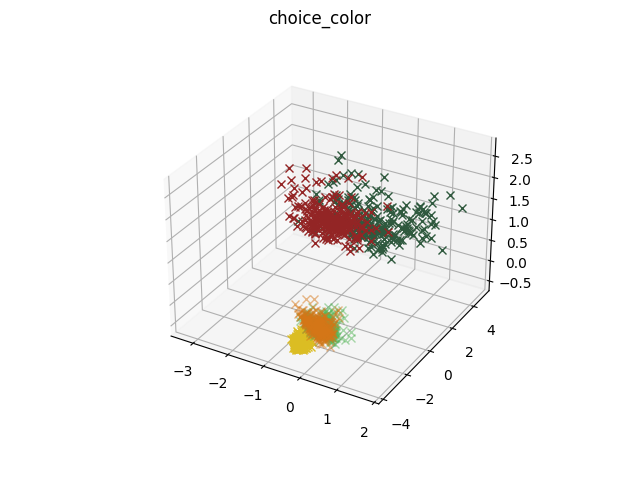

In [10]:
plot3d_with_fps(activity_dict_all, fp_gl_dict, fp_rl_dict, pca_all, H_idx, targ_arrange, color_dict_choice_c, 'choice_color', fix_points_only = True)

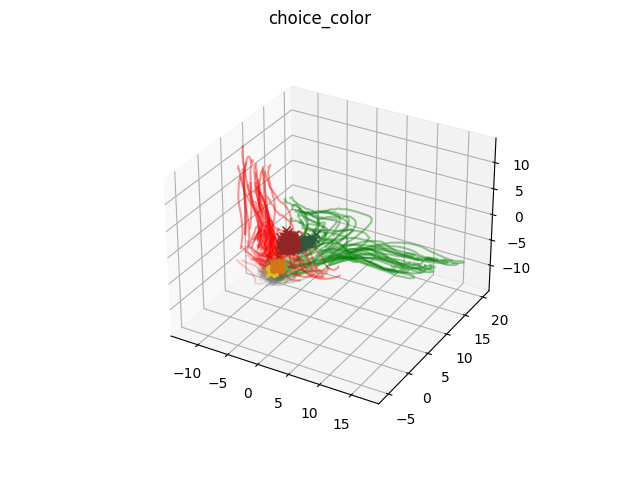

In [11]:
plot3d_with_fps(activity_dict_all, fp_gl_dict, fp_rl_dict, pca_all, H_idx, targ_arrange, color_dict_choice_c, 'choice_color')

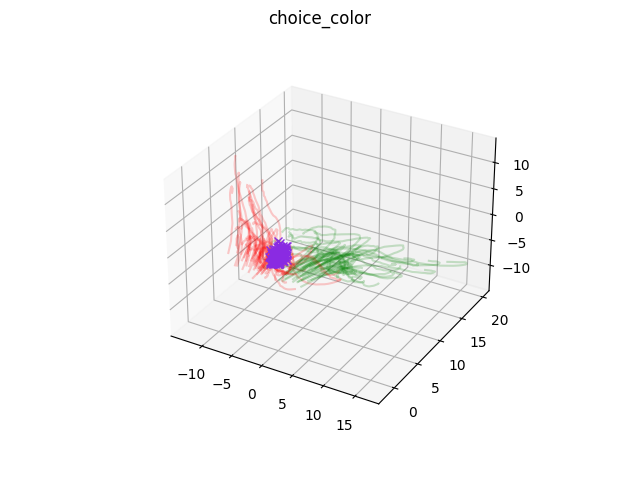

In [18]:
plot3d_with_fps(activity_dict_all, fp_rl_dict, pca_all, correct_idx, targ_arrange, color_dict_choice_c, 'choice_color')

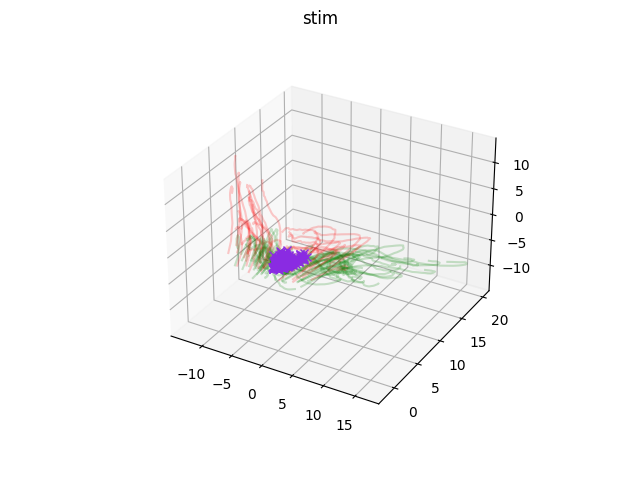

In [16]:
plot3d_with_fps(activity_dict_all, fp_all_dict, pca_all, correct_idx, stim_dir, color_dict_stim, 'stim')

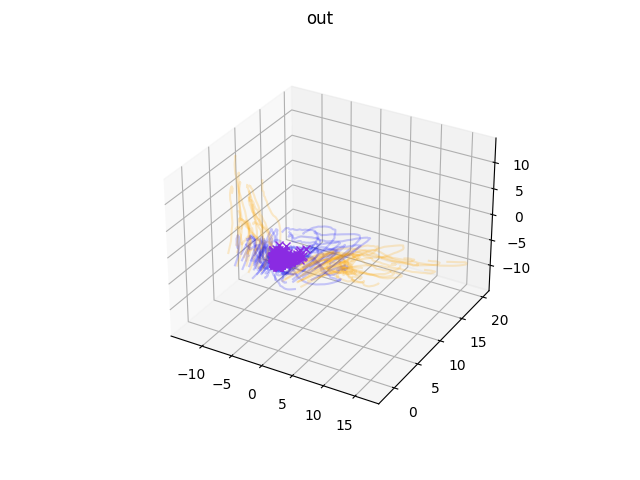

In [23]:
plot3d_with_fps(activity_dict_all, fp_all_dict, pca_all, correct_idx, out, color_dict_out, 'out')

In [ ]:
plot3d_with_fps(activity_dict_m2, fp_m2_dict, pca_m2, correct_idx, m2_ipsi_sac, color_dict_out, 'out')

In [29]:
f_dir = "cutSpec_model"
lr = 0.02
rep = 0
update_parameters({'rep': rep,
                    'save_fn': 'model_results_%d_lr%f.pkl' % (rep, lr),
                    'batch_size': par['test_batch_size'],
                    'num_iterations': par['num_test_iterations'],
                    'coherence_levels': par['test_coherence_levels'],
                    'weight_fn': 'weight_%d.pth' % (rep),
                    'learning_rate': lr, 
                    'save_test_out': False})
n = SimpleNamespace(**load_test_data(f_dir, "test_output_lr%f_rep%d.h5" % (lr, rep)))
normalized_h = min_max_normalize(n.h)

stim_dir = n.stim_dir
reshaped_out =  n.desired_out[-1, :, :]
out = [0 if reshaped_out[i, 0] == 1 else 1 for i in range(reshaped_out.shape[0])]
cond1_idx = np.logical_and(stim_dir==135, np.array(out)==0)
cond2_idx = np.logical_and(stim_dir==135, np.array(out)==1)
cond3_idx = np.logical_and(stim_dir==315, np.array(out)==0)
cond4_idx = np.logical_and(stim_dir==315, np.array(out)==1)

cond1_h = np.mean(normalized_h[:, cond1_idx, :], axis=1)
cond2_h = np.mean(normalized_h[:, cond2_idx, :], axis=1)
cond3_h = np.mean(normalized_h[:, cond3_idx, :], axis=1)
cond4_h = np.mean(normalized_h[:, cond4_idx, :], axis=1)

prep_h_mat = np.concatenate((cond1_h, cond2_h, cond3_h, cond4_h), axis=0)

m1_contra_sac, m1_ipsi_sac = find_sac_idx(n.y, True)
m2_contra_sac, m2_ipsi_sac = find_sac_idx(n.y, False)

mt_idx = np.concatenate([range(40, 80), range(120, 160), range(170, 180), range(190, 200)])
mm_idx = np.concatenate([range(40), range(80, 120), range(160, 170), range(180, 190)])
m1_idx = np.concatenate([range(40), range(40, 80), range(160, 170), range(170, 180)])
m2_idx = np.concatenate([range(80, 120), range(120, 160), range(180, 190), range(190, 200)])
# m_idx = np.arange(200)
mt_h = prep_h_mat[:, mt_idx]
mm_h = prep_h_mat[:, mm_idx]
m1_h = prep_h_mat[:, m1_idx]
m2_h = prep_h_mat[:, m2_idx]

correct_idx =  np.where(n.correct_idx)[0]
incorrect_idx = np.where(~n.correct_idx)[0]

pca_mm = PCA(n_components=3)
pca_mm.fit(mm_h)
pca_mt = PCA(n_components=3)
pca_mt.fit(mm_h)
pca_all = PCA(n_components=3)
pca_all.fit(prep_h_mat)
pca_m1 = PCA(n_components=3)
pca_m1.fit(m1_h)
pca_m2 = PCA(n_components=3)
pca_m2.fit(m2_h)

activity_dict_mm = [normalized_h[:, i, mm_idx] for i in range(normalized_h.shape[1])]
activity_dict_mt = [normalized_h[:, i, mt_idx] for i in range(normalized_h.shape[1])]
activity_dict_all = [normalized_h[:, i, :] for i in range(normalized_h.shape[1])]
activity_dict_m1 = [normalized_h[:, i, m1_idx] for i in range(normalized_h.shape[1])]
activity_dict_m2 = [normalized_h[:, i, m2_idx] for i in range(normalized_h.shape[1])]

In [30]:
model = Model(par, n.neural_input, train=False)
model.reset_batch()

fix_fp_finder = build_finder(13, n, model)
target_fp_finder = build_finder(35, n, model)
stim_fp_finder = build_finder(58, n, model)

Optimizing with Adam(lr=ExponentialDecay(0.2, decay_steps=1, decay_rate=0.9999), last_call=-1), beta1=0.9, beta2=0.999, eps=1e-08) to find fixed points:
    Batches 1-500 in 1.21 sec, Training loss 0.0000053361
    Batches 501-1000 in 1.36 sec, Training loss 0.0000037951
    Stop optimization as mean training loss 0.0000037951 is below tolerance 0.0000050000.
Optimizing with Adam(lr=ExponentialDecay(0.2, decay_steps=1, decay_rate=0.9999), last_call=-1), beta1=0.9, beta2=0.999, eps=1e-08) to find fixed points:
    Batches 1-500 in 1.23 sec, Training loss 0.0000107284
    Batches 501-1000 in 1.10 sec, Training loss 0.0000064415
    Batches 1001-1500 in 1.10 sec, Training loss 0.0000046055
    Stop optimization as mean training loss 0.0000046055 is below tolerance 0.0000050000.
Optimizing with Adam(lr=ExponentialDecay(0.2, decay_steps=1, decay_rate=0.9999), last_call=-1), beta1=0.9, beta2=0.999, eps=1e-08) to find fixed points:
    Batches 1-500 in 1.10 sec, Training loss 0.0000186834
   

In [31]:
fix_all_fp =  fix_fp_finder.fixed_points['h']
target_all_fp = target_fp_finder.fixed_points['h']
stim_all_fp = stim_fp_finder.fixed_points['h']

fp_all_dict = {'fix': fix_all_fp, 'target': target_all_fp, 'stim': stim_all_fp}

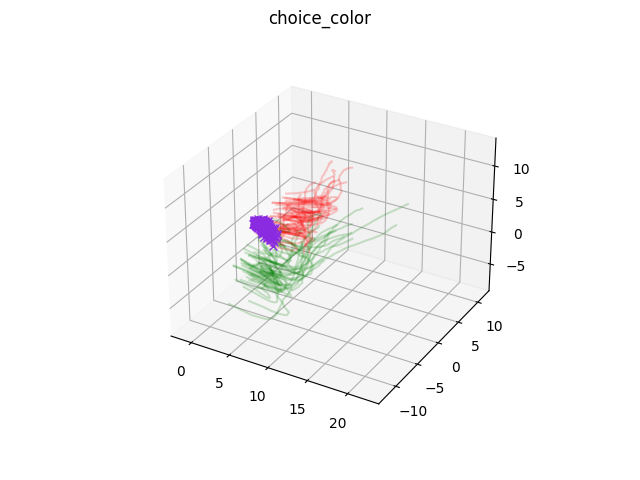

In [32]:
targ_arrange = recover_targ_loc(n.desired_out, n.stim_dir)[-1, :]
targ_arrange.shape
plot3d_with_fps(activity_dict_all, fp_all_dict, pca_all, correct_idx, targ_arrange, color_dict_choice_c, 'choice_color')

In [33]:
f_dir = "cutNonspec_model"
lr = 0.02
rep = 0
update_parameters({'rep': rep,
                    'save_fn': 'model_results_%d_lr%f.pkl' % (rep, lr),
                    'batch_size': par['test_batch_size'],
                    'num_iterations': par['num_test_iterations'],
                    'coherence_levels': par['test_coherence_levels'],
                    'weight_fn': 'weight_%d.pth' % (rep),
                    'learning_rate': lr, 
                    'save_test_out': False})
n = SimpleNamespace(**load_test_data(f_dir, "test_output_lr%f_rep%d.h5" % (lr, rep)))
normalized_h = min_max_normalize(n.h)

stim_dir = n.stim_dir
reshaped_out =  n.desired_out[-1, :, :]
out = [0 if reshaped_out[i, 0] == 1 else 1 for i in range(reshaped_out.shape[0])]
cond1_idx = np.logical_and(stim_dir==135, np.array(out)==0)
cond2_idx = np.logical_and(stim_dir==135, np.array(out)==1)
cond3_idx = np.logical_and(stim_dir==315, np.array(out)==0)
cond4_idx = np.logical_and(stim_dir==315, np.array(out)==1)

cond1_h = np.mean(normalized_h[:, cond1_idx, :], axis=1)
cond2_h = np.mean(normalized_h[:, cond2_idx, :], axis=1)
cond3_h = np.mean(normalized_h[:, cond3_idx, :], axis=1)
cond4_h = np.mean(normalized_h[:, cond4_idx, :], axis=1)

prep_h_mat = np.concatenate((cond1_h, cond2_h, cond3_h, cond4_h), axis=0)

m1_contra_sac, m1_ipsi_sac = find_sac_idx(n.y, True)
m2_contra_sac, m2_ipsi_sac = find_sac_idx(n.y, False)

mt_idx = np.concatenate([range(40, 80), range(120, 160), range(170, 180), range(190, 200)])
mm_idx = np.concatenate([range(40), range(80, 120), range(160, 170), range(180, 190)])
m1_idx = np.concatenate([range(40), range(40, 80), range(160, 170), range(170, 180)])
m2_idx = np.concatenate([range(80, 120), range(120, 160), range(180, 190), range(190, 200)])
# m_idx = np.arange(200)
mt_h = prep_h_mat[:, mt_idx]
mm_h = prep_h_mat[:, mm_idx]
m1_h = prep_h_mat[:, m1_idx]
m2_h = prep_h_mat[:, m2_idx]

correct_idx =  np.where(n.correct_idx)[0]
incorrect_idx = np.where(~n.correct_idx)[0]

pca_mm = PCA(n_components=3)
pca_mm.fit(mm_h)
pca_mt = PCA(n_components=3)
pca_mt.fit(mm_h)
pca_all = PCA(n_components=3)
pca_all.fit(prep_h_mat)
pca_m1 = PCA(n_components=3)
pca_m1.fit(m1_h)
pca_m2 = PCA(n_components=3)
pca_m2.fit(m2_h)

activity_dict_mm = [normalized_h[:, i, mm_idx] for i in range(normalized_h.shape[1])]
activity_dict_mt = [normalized_h[:, i, mt_idx] for i in range(normalized_h.shape[1])]
activity_dict_all = [normalized_h[:, i, :] for i in range(normalized_h.shape[1])]
activity_dict_m1 = [normalized_h[:, i, m1_idx] for i in range(normalized_h.shape[1])]
activity_dict_m2 = [normalized_h[:, i, m2_idx] for i in range(normalized_h.shape[1])]

In [34]:
model = Model(par, n.neural_input, train=False)
model.reset_batch()

fix_fp_finder = build_finder(13, n, model)
target_fp_finder = build_finder(35, n, model)
stim_fp_finder = build_finder(58, n, model)

Optimizing with Adam(lr=ExponentialDecay(0.2, decay_steps=1, decay_rate=0.9999), last_call=-1), beta1=0.9, beta2=0.999, eps=1e-08) to find fixed points:
    Batches 1-500 in 1.17 sec, Training loss 0.0000060875
    Batches 501-1000 in 1.25 sec, Training loss 0.0000031944
    Stop optimization as mean training loss 0.0000031944 is below tolerance 0.0000050000.
Optimizing with Adam(lr=ExponentialDecay(0.2, decay_steps=1, decay_rate=0.9999), last_call=-1), beta1=0.9, beta2=0.999, eps=1e-08) to find fixed points:
    Batches 1-500 in 1.24 sec, Training loss 0.0000102689
    Batches 501-1000 in 1.25 sec, Training loss 0.0000066776
    Batches 1001-1500 in 1.46 sec, Training loss 0.0000045053
    Stop optimization as mean training loss 0.0000045053 is below tolerance 0.0000050000.
Optimizing with Adam(lr=ExponentialDecay(0.2, decay_steps=1, decay_rate=0.9999), last_call=-1), beta1=0.9, beta2=0.999, eps=1e-08) to find fixed points:
    Batches 1-500 in 1.18 sec, Training loss 0.0000239909
   

In [35]:
fix_all_fp =  fix_fp_finder.fixed_points['h']
target_all_fp = target_fp_finder.fixed_points['h']
stim_all_fp = stim_fp_finder.fixed_points['h']

fp_all_dict = {'fix': fix_all_fp, 'target': target_all_fp, 'stim': stim_all_fp}

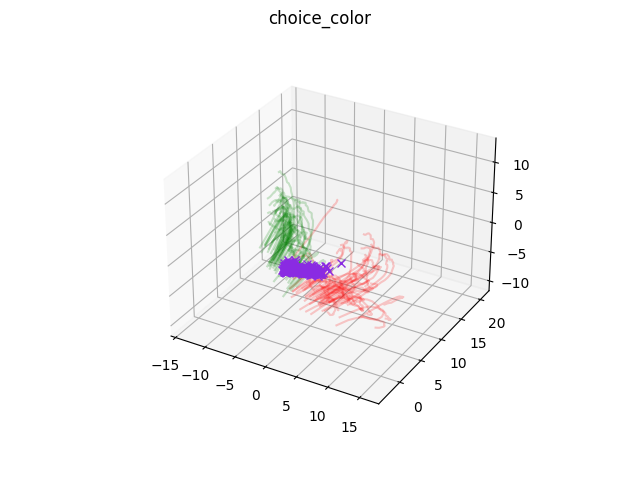

In [36]:
targ_arrange = recover_targ_loc(n.desired_out, n.stim_dir)[-1, :]
targ_arrange.shape
plot3d_with_fps(activity_dict_all, fp_all_dict, pca_all, correct_idx, targ_arrange, color_dict_choice_c, 'choice_color')